# The Delta wave in the UK seems to be more contagious but not as fatal as the previous wave of COVID. Is Israel's current wave similar?

![The uk has this. Is Israel in a similar situation?](uk_waves.png)

# Data Gathering

To adress this question, we would need information on the following:
1. Daily COVID cases
2. Daily hospitalisations 
3. Daily COVID related deaths 
4. Start times of each COVID wave in Israel

1-2 we will retrieve from data-gov:
https://data.gov.il/dataset/covid-19

3 from: https://covid19.who.int/info

Wave beginning date is tricky as there is no easy google-able date online, we will have to figure it out from the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# World Health Organization (WHO) data for new cases and mortality

In [31]:
who = pd.read_csv('WHO-COVID-19-global-data.csv')
who.head()

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,2020-01-03,AF,Afghanistan,EMRO,0,0,0,0
1,2020-01-04,AF,Afghanistan,EMRO,0,0,0,0
2,2020-01-05,AF,Afghanistan,EMRO,0,0,0,0
3,2020-01-06,AF,Afghanistan,EMRO,0,0,0,0
4,2020-01-07,AF,Afghanistan,EMRO,0,0,0,0


In [32]:
#filter to focus on Israeli cases
who_israel = who[who['Country']=='Israel'].copy()
len(who_israel)

549

# Basic Data Exploration

In [33]:
who_israel['Date_reported'] = pd.to_datetime(who_israel['Date_reported'])

WHO reports less cases than Israel's health ministry.

In [34]:
who_casses = who_israel[['Date_reported','New_cases']].copy()

who_deaths = who_israel[['Date_reported','New_deaths']].copy()

In [35]:
def smooth(df,column_to_weekly_smooth):
    '''
    smoothen data per week
    '''
    df[f'{column_to_weekly_smooth}_{"smooth"}'] = df[column_to_weekly_smooth].rolling(7).mean()


smooth(who_casses,'New_cases')
smooth(who_deaths,'New_deaths')

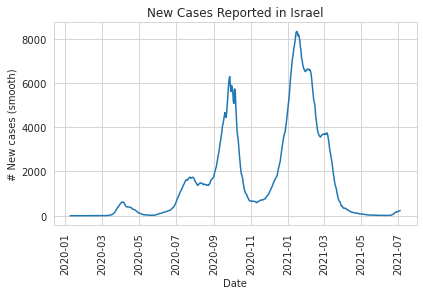

In [39]:
sns.lineplot(x='Date_reported',y='New_cases_smooth',data=who_casses)
plt.xticks(rotation = 'vertical')
plt.tight_layout()
plt.title("New Cases Reported in Israel")
plt.xlabel("Date")
plt.ylabel("# New cases (smooth)")
plt.show()

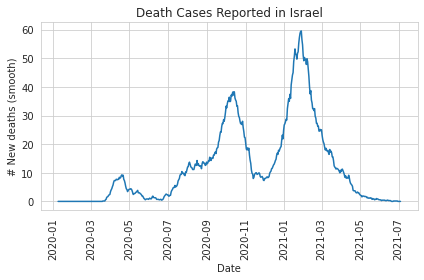

In [40]:
sns.lineplot(x='Date_reported',y='New_deaths_smooth',data=who_deaths)
plt.xticks(rotation = 'vertical')
plt.title("Death Cases Reported in Israel")
plt.xlabel("Date")
plt.ylabel("# New deaths (smooth)")
plt.tight_layout()
plt.show()

In [10]:
who_israel['weekly_mean_cases'] = who_israel['New_cases'].rolling(7).mean()
who_israel['weekly_mean_deaths'] = who_israel['New_deaths'].rolling(7).mean()
who_israel.head(8)

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,weekly_mean_cases,weekly_mean_deaths
56044,2020-01-03,IL,Israel,EURO,0,0,0,0,NaN,NaN
56045,2020-01-04,IL,Israel,EURO,0,0,0,0,NaN,NaN
56046,2020-01-05,IL,Israel,EURO,0,0,0,0,NaN,NaN
56047,2020-01-06,IL,Israel,EURO,0,0,0,0,NaN,NaN
56048,2020-01-07,IL,Israel,EURO,0,0,0,0,NaN,NaN
56049,2020-01-08,IL,Israel,EURO,0,0,0,0,NaN,NaN
56050,2020-01-09,IL,Israel,EURO,0,0,0,0,0.0,0.0
56051,2020-01-10,IL,Israel,EURO,0,0,0,0,0.0,0.0


# Split to Waves

In [11]:
wave_2 = who_israel[who_israel['Date_reported']>='2021-06-05']\
[['Date_reported','New_cases','New_deaths','weekly_mean_cases','weekly_mean_deaths']].copy().reset_index()
wave_2['wave'] = 'current'
wave_2['wave-day'] = wave_2.index


index_of_march_1_2020 = who_israel[who_israel['Date_reported']=='2020-03-01'].index[0]
wave_1 = who_israel[(who_israel.index >= index_of_march_1_2020)&(
    who_israel.index < index_of_march_1_2020+len(wave_2))]\
[['Date_reported','New_cases','New_deaths','weekly_mean_cases','weekly_mean_deaths']].copy().reset_index()
wave_1['wave'] = 'first'
wave_1['wave-day'] = wave_1.index


waves_for_compere = pd.concat([wave_1,wave_2])

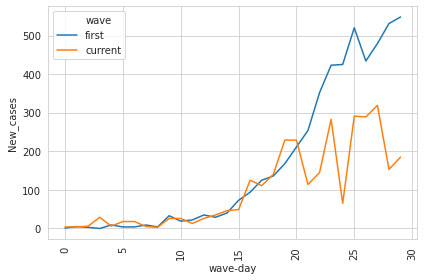

In [12]:
sns.lineplot(x='wave-day',y='New_cases',hue='wave',data=waves_for_compere)
plt.xticks(rotation = 'vertical')
plt.tight_layout()
plt.show()

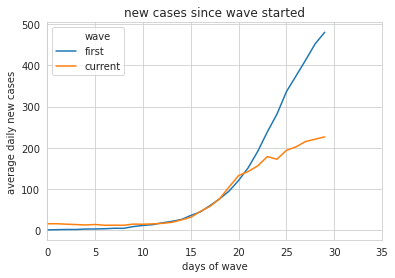

In [21]:
ax = sns.lineplot(x='wave-day',y='weekly_mean_cases',hue='wave',data=waves_for_compere)
ax.set(xlim=(0,35))
ax.set(xlabel='days of wave')
ax.set(ylabel='average daily new cases')
ax.set(title='new cases since wave started')
plt.savefig('cases.png',dpi=720)
plt.show()

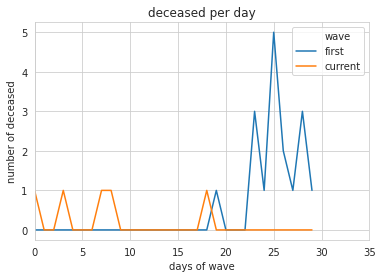

In [14]:
ax = sns.lineplot(x='wave-day',y='New_deaths',hue='wave',data=waves_for_compere)
ax.set(xlim=(0,35))
ax.set(xlabel='days of wave')
ax.set(ylabel='number of deceased')
ax.set(title='deceased per day')
plt.savefig('mortality.png',dpi=720)
plt.show()

In [15]:
hospitalized = pd.read_excel('corona_hospitalization_ver_00300.xlsx')

In [16]:
hospitalized.head()
hospitalized['date'] = hospitalized['תאריך']
hospitalized['hospitalized_number']=hospitalized['מאושפזים']

In [17]:
hospitalized['date'].head()

0   2020-03-11
1   2020-03-12
2   2020-03-13
3   2020-03-14
4   2020-03-15
Name: date, dtype: datetime64[ns]

In [18]:
current_wave = hospitalized[hospitalized['date']>='2021-06-11'].copy().reset_index()
current_wave['wave-day'] = current_wave.index+11
current_wave['wave'] = 'current'
current_wave['weekly_mean_in_hospital'] = current_wave['hospitalized_number'].rolling(7).mean()


first_wave = hospitalized[hospitalized.index<len(current_wave)].copy().reset_index()
first_wave['wave-day'] = first_wave.index+11
first_wave['wave'] = 'first'
first_wave['weekly_mean_in_hospital'] = first_wave['hospitalized_number'].rolling(7).mean()

hos_waves_compere = pd.concat([first_wave,current_wave])

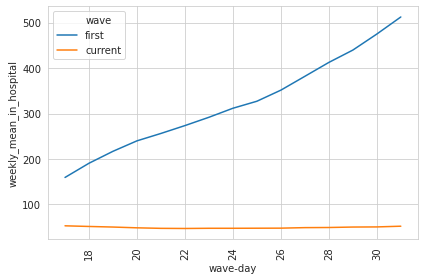

In [20]:
sns.lineplot(x='wave-day',y='weekly_mean_in_hospital',hue='wave',data=hos_waves_compere)
plt.xticks(rotation = 'vertical')
plt.tight_layout()
plt.savefig('hospitalized.png',dpi=720)
plt.show()

In [23]:
deceased = pd.read_csv('corona_deceased_ver_00121.csv')
deceased.head()

,gender,Age_group,Ventilated,Time_between_positive_and_hospitalization,Length_of_hospitalization,Time_between_positive_and_death
0,נקבה,80-89,0.0,18.0,1.0,18.0
1,נקבה,80-89,1.0,1.0,19.0,20.0
2,זכר,90+,1.0,10.0,1.0,10.0
3,זכר,70-79,0.0,11.0,0.0,11.0
4,זכר,60-69,0.0,3.0,0.0,5.0


In [24]:
deceased['Time_between_positive_and_death'].describe()

count    6369.000000
mean       17.205684
std        18.877500
min        -2.000000
25%         7.000000
50%        13.000000
75%        21.000000
max       324.000000
Name: Time_between_positive_and_death, dtype: float64

In [30]:
deceased['Time_between_positive_and_death'].quantile([i/10 for i in range(1,11)])

0.1      4.0
0.2      6.0
0.3      8.0
0.4     10.0
0.5     13.0
0.6     15.0
0.7     19.0
0.8     24.0
0.9     34.0
1.0    324.0
Name: Time_between_positive_and_death, dtype: float64

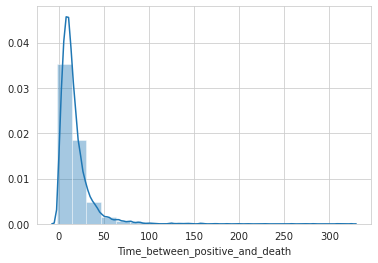

In [27]:
sns.distplot(deceased['Time_between_positive_and_death'],bins=20,)